In [55]:
#import libraries and set the vectorBT portfolio settings
import numpy as np
import pandas as pd

np.random.seed(42)

In [154]:
import datetime as dt
# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[prices.index <= dt.datetime(2023, 12, 30)]

In [155]:
limite_superior = 77
limite_inferior = 23

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [156]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados

True


In [157]:
import riskfolio as rp
import pandas as pd

# TODO: Verificar quantidade de tempo para rebalanceamento
# TODO: Constraints da otimização
def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # Usando Ledoit-Wolf shrinkage para tornar a matriz de cov positiva definida

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-09-22,0.010939,6.313835e-03,3.212465e-09,3.698271e-09,3.752724e-09,4.394183e-08,1.015948e-08,1.410225e-02,3.327835e-03,5.831697e-09,...,0.016068,2.659612e-08,1.651361e-03,0.004018,2.247479e-08,8.113560e-09,1.110454e-08,7.830996e-03,3.143604e-02,2.924343e-07
2015-09-25,0.011085,5.586405e-03,1.271861e-09,1.478704e-09,1.504345e-09,1.556931e-08,3.709318e-09,1.493545e-02,3.755507e-03,2.307426e-09,...,0.016511,1.246116e-08,1.668632e-03,0.003553,8.640472e-09,2.672939e-09,4.049101e-09,7.126850e-03,3.062118e-02,3.998921e-05
2015-09-28,0.011173,5.515225e-03,1.387705e-09,1.620538e-09,1.653001e-09,1.619186e-08,3.912524e-09,1.493014e-02,3.686140e-03,2.533342e-09,...,0.016863,1.244847e-08,1.596533e-03,0.003362,9.272543e-09,2.932584e-09,4.179807e-09,7.141262e-03,3.028556e-02,3.654335e-05
2015-12-14,0.004816,1.046289e-07,1.900317e-09,3.355935e-09,3.023296e-09,1.076345e-08,5.003761e-09,1.994666e-02,4.016431e-03,6.462993e-09,...,0.027932,7.735320e-04,5.328073e-08,0.005972,1.300631e-08,1.080406e-03,6.690353e-09,1.538603e-02,2.433127e-02,2.563144e-08
2015-12-16,0.004222,7.034549e-05,5.022360e-10,8.818287e-10,7.970695e-10,2.734067e-09,1.366979e-09,1.984533e-02,3.914721e-03,1.638919e-09,...,0.027800,6.077280e-04,1.889327e-08,0.006254,3.543122e-09,1.239476e-03,1.749389e-09,1.541724e-02,2.397741e-02,7.767186e-09
2016-01-18,0.002040,1.058087e-03,3.267903e-10,5.690308e-10,5.265071e-10,1.344988e-09,7.181803e-10,1.860607e-02,5.210743e-03,8.978305e-10,...,0.028279,1.714277e-03,7.107455e-09,0.005306,1.849030e-09,2.564695e-04,1.038507e-09,1.160432e-02,2.181010e-02,1.320441e-08
2016-04-01,0.014528,9.277663e-03,1.359518e-10,2.500153e-10,2.187750e-10,2.717353e-09,3.094879e-10,1.985304e-02,3.653007e-03,3.855509e-10,...,0.033383,8.266606e-09,8.404188e-09,0.006796,8.906318e-10,1.603978e-03,3.707470e-10,6.167121e-03,2.308629e-02,1.278138e-09
2016-04-04,0.014884,8.988126e-03,1.889470e-10,3.534150e-10,3.058091e-10,3.211269e-09,4.285354e-10,1.952879e-02,2.831189e-03,5.478517e-10,...,0.034191,1.086964e-08,3.268664e-08,0.006994,1.245496e-09,1.403139e-03,5.267919e-10,5.414374e-03,2.228108e-02,1.981673e-09
2016-04-06,0.014886,9.057821e-03,1.441176e-10,2.671716e-10,2.314774e-10,2.703631e-09,3.289773e-10,1.947668e-02,3.037402e-03,3.992597e-10,...,0.034545,9.812808e-09,1.755487e-08,0.007055,9.721232e-10,1.154353e-03,4.058450e-10,5.493003e-03,2.246832e-02,1.604477e-09
2017-05-19,0.048738,2.071438e-02,6.896333e-10,1.521293e-09,1.205138e-09,4.000474e-02,8.752094e-10,1.768645e-02,1.340914e-02,1.411639e-09,...,0.028971,1.115886e-08,6.176005e-09,0.029906,3.081381e-02,7.932361e-10,1.179351e-09,1.882073e-08,5.126711e-03,2.179556e-09


[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


<Axes: title={'center': 'Equity Progression'}>

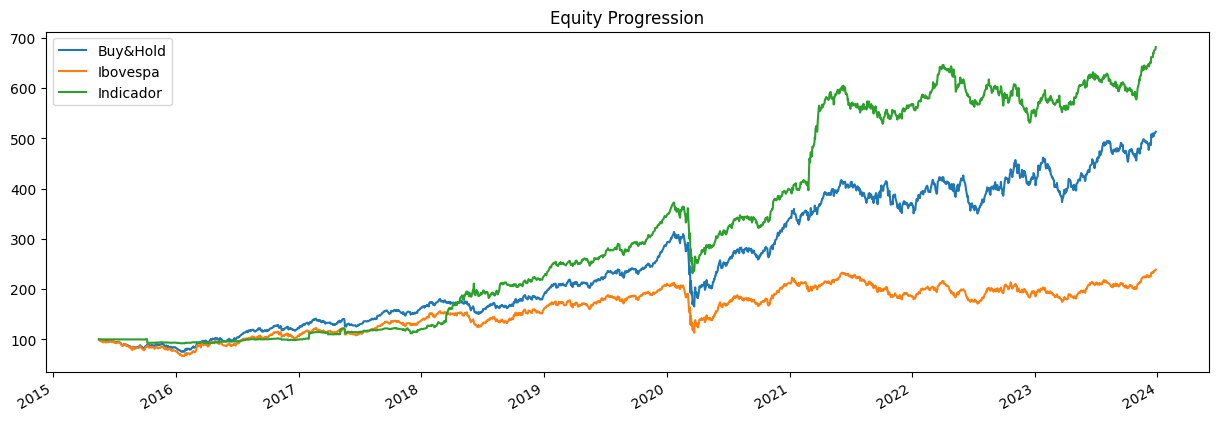

In [158]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Assumindo que você já tem um DataFrame 'prices' com os dados de preços de ações
# Exemplo:
# prices = yf.download(['AAPL', 'MSFT', 'GOOG'], start='2020-01-01', end='2024-01-01')['Adj Close']

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])

# Criando o backtest
backtests = [
    bt.Backtest(strat_buy_hold, prices, initial_capital=1000000000),
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [159]:
# Resultados
results.display()

Stat                 Buy&Hold    Ibovespa    Indicador
-------------------  ----------  ----------  -----------
Start                2015-05-17  2015-05-17  2015-05-17
End                  2023-12-27  2023-12-27  2023-12-27
Risk-free rate       0.00%       0.00%       0.00%

Total Return         413.27%     138.76%     581.77%
Daily Sharpe         0.92        0.54        1.26
Daily Sortino        1.41        0.84        2.03
CAGR                 20.91%      10.63%      24.96%
Max Drawdown         -47.30%     -46.82%     -37.78%
Calmar Ratio         0.44        0.23        0.66

MTD                  3.99%       5.39%       6.29%
3m                   8.33%       17.38%      14.54%
6m                   16.25%      14.19%      10.14%
YTD                  19.41%      21.96%      22.37%
1Y                   22.25%      23.86%      23.97%
3Y (ann.)            15.13%      4.08%       19.57%
5Y (ann.)            23.32%      9.45%       25.53%
10Y (ann.)           -           -           -
Since

In [95]:
trans = results.get_transactions('Indicador')

In [21]:
trans

price    quantity
Date       Security                       
2015-08-07 ABEV3.SA  14.226474    660898.0
           ALPA4.SA   5.404266    993589.0
           BRAP4.SA   1.493313         2.0
           BRFS3.SA  65.516464    159001.0
           BRKM5.SA   8.704030    124459.0
...                        ...         ...
2024-08-05 TIMS3.SA  17.036510   -441289.0
           TRPL4.SA  24.389999 -15824448.0
           VALE3.SA  57.020000   1866240.0
           VIVT3.SA  48.672100  -5993940.0
           WEGE3.SA  48.798908   3887936.0

[966 rows x 2 columns]